In [3]:
import  numpy as np
import cv2

# center ,angle , scale
cv2.getRotationMatrix2D((0,0),60,1),np.sin(60/180.0 *np.pi)

(array([[ 0.5      ,  0.8660254,  0.       ],
        [-0.8660254,  0.5      ,  0.       ]]),
 0.8660254037844386)

In [4]:
'''

'''
theta = 0.8
scale = 2
# 旋转操作
rot = np.array([
    [np.cos(theta), np.sin(theta)],
    [-np.sin(theta), np.cos(theta)]
])
# scale
sca = np.array([
    [scale, 0],
    [0, scale]
])

np.allclose(rot @ sca, sca @ rot)

True

In [7]:
'''
对于图像的 resize操作实现
1、先缩放
2、移到原点
3、移到中心
'''

origin = np.array([300,500],dtype=float)
dst = np.array([640,640],dtype=float)
print('dst/origin.....',dst/origin) # 对于每一个分量都会除
scale = min(dst/origin)
# scale S
#-(scale * origin[0] * 0.5) 第0维移动到原点，所以只用平移移动1/2的宽高维度 O
# + (dst[0]*0.5) 移动到目的图像中心点 T
# p' = TOSP (为什么会是 左乘呢)
M=np.array([
    [scale,0, -(scale * origin[0] * 0.5) + (dst[0]*0.5)],
    [0,scale,-(scale * origin[1] * 0.5) + (dst[1]*0.5)],
    [0,0,1]
])
M

dst/origin..... [2.13333333 1.28      ]


array([[  1.28,   0.  , 128.  ],
       [  0.  ,   1.28,   0.  ],
       [  0.  ,   0.  ,   1.  ]])

In [8]:
np.linalg.inv(M) # 求逆

array([[   0.78125,    0.     , -100.     ],
       [   0.     ,    0.78125,    0.     ],
       [   0.     ,    0.     ,    1.     ]])

In [9]:
k = scale
b1 = M[0, 2]
b2 = M[1, 2]

invM = np.array([
    [1 / k, 0, -b1/k],
    [0, 1 / k, -b2/k]
])
invM

array([[   0.78125,    0.     , -100.     ],
       [   0.     ,    0.78125,   -0.     ]])

cat1.size()------> (188, 316, 3)


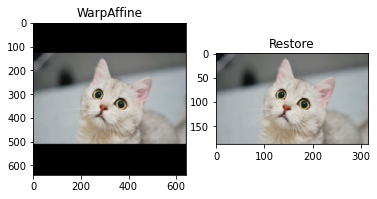

In [22]:
import matplotlib.pyplot as plt
def inv_align(M):
    k = M[0, 0]
    b1 = M[0, 2]
    b2 = M[1, 2]
    return np.array([
        [1/k, 0, -b1/k],
        [0, 1/k, -b2/k]
    ])

def align(image, dst_size):

    oh, ow = image.shape[:2]
    dh, dw = dst_size
    scale = min(dw/ow, dh/oh)

    M = np.array([
        [scale, 0, -scale * ow * 0.5 + dw * 0.5],
        [0, scale, -scale * oh * 0.5 + dh * 0.5]
    ])
    # M 是变换矩阵 ,dst_size
    return cv2.warpAffine(image, M, dst_size), M, inv_align(M)

cat1 = cv2.imread('cat1.png')
print('cat1.size()------>',cat1.shape) # (188, 316, 3)
acat1,M,inv = align(cat1, (640, 640))

plt.subplot(1,2,1)
plt.title('WarpAffine')
plt.imshow(acat1[...,::-1])

# 逆变换之后
resact1 = cv2.warpAffine(acat1, inv, cat1.shape[:2][::-1])
plt.subplot(1, 2, 2)
plt.title("Restore")
plt.imshow(resact1[..., ::-1])

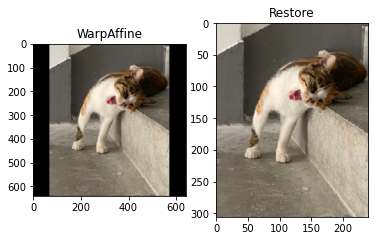

In [23]:
cat2 = cv2.imread("cat2.png")
acat2, M, inv = align(cat2, (640, 640))

plt.subplot(1, 2, 1)
plt.title("WarpAffine")
plt.imshow(acat2[..., ::-1])

resact2 = cv2.warpAffine(acat2, inv, cat2.shape[:2][::-1])
plt.subplot(1, 2, 2)
plt.title("Restore")
plt.imshow(resact2[..., ::-1])

- 测试插值方法(线性和双线性)

In [25]:
# 双线性插值
p0 = 3;        p1 = 5
p2 = 6;        p3 = 8

pos = 0.6,0.8
p0_area = (1-pos[0]) * (1-pos[1])
p1_area = pos[0] * (1-pos[1])
p2_area = (1-pos[0]) * pos[1]
p3_area = pos[0] * pos[1]

value = p0_area*p0 + p1_area*p1 + p2_area*p2 + p3_area*p3
print(value)
# 6.6

6.6


[26 19 16]


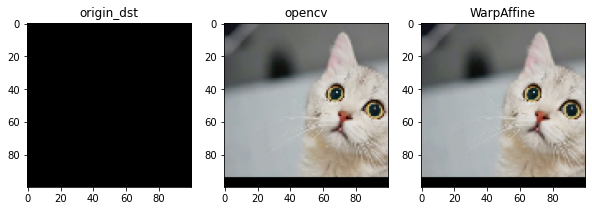

In [37]:
def pyWarpAffine(image,M,dst_size,constant=(0,0,0)):
    # 如果输入的M矩阵格式是Origin->Dst,我们要求的是他的逆矩阵
    M=cv2.invertAffineTransform(M)
    constant = np.array(constant)
    ih,iw = image.shape[0:2] # image.shape()
    # print(image.shape) # (188, 316, 3)
    dw,dh = dst_size
    dst = np.full((dh,dw,3),constant,dtype=np.uint8)
    irange = lambda p:p[0]>=0 and p[0]<iw and p[1]>=0 and p[1]<ih

    for y in range(dh):
        for x in range(dw):
            # 对于每一块像素区域
            homogeneous = np.array([[x,y,1]]).T
            ox,oy = M @ homogeneous

            low_ox = int(np.floor(ox))
            low_oy = int(np.floor(oy))
            high_ox = low_ox+1
            high_oy = low_oy+1
            # p0     p1
            #      o
            # p2     p3

            pos = ox - low_ox, oy - low_oy
            # print('pos=================',pos)
            # pos================= (array([0.90381057]), array([0.47302995]))
            p0_area = (1 - pos[0]) * (1 - pos[1])
            p1_area = pos[0] * (1 - pos[1])
            p2_area = (1 - pos[0]) * pos[1]
            p3_area = pos[0] * pos[1]

            p0 = low_ox,low_oy
            p1 = high_ox,low_oy
            p2 = low_ox,high_oy
            p3 = high_ox,high_oy

            # (x,y)
            p0_value = image[p0[1], p0[0]] if irange(p0) else constant
            p1_value = image[p1[1], p1[0]] if irange(p1) else constant
            p2_value = image[p2[1], p2[0]] if irange(p2) else constant
            p3_value = image[p3[1], p3[0]] if irange(p3) else constant
            dst[y,x] = p0_area*p0_value + p1_area * p1_value + p2_area * p2_value + p3_area * p3_value
            # [26 19 16] (x,y,c)
            if x == 0 and y==0:
                print(dst[y,x])
    return dst



cat1 = cv2.imread('cat1.png')
M = cv2.getRotationMatrix2D((0,0),0,0.5)
# 比较opencv方法和本方法
acat1_cv = cv2.warpAffine(cat1,M,(100,100))
acat1_py = pyWarpAffine(cat1,M,(100,100))

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title('origin_dst')
plt.imshow(np.full((100,100,3),(0,0,0),dtype=np.uint8))

plt.subplot(1,3,2)
plt.title('opencv')
plt.imshow(acat1_cv[...,::-1])

plt.subplot(1,3,3)
plt.title('WarpAffine')
plt.imshow(acat1_py[...,::-1])